## Titanic
### Analysis and modeling of the Titanic dataset
This Jupyter notebook analysis and models the famous Titanic dataset using Polar and logistic regression.

This is *not* an attempt to find the best predictive model.

### 1. Preparation

#### Import packages

In [1]:
import os
import numpy as np
import polars as pl
#import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt

#### List files and folders

In [2]:
os.listdir()

['README.md', '.gitignore', 'titanic.csv', 'venv', '.git', 'titanic.ipynb']

#### Load dataset

In [3]:
df = pl.read_csv("titanic.csv", separator=",")

df.head(3)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
1,0,3,"""Braund, Mr. Owen Harris""","""male""",22.0,1,0,"""A/5 21171""",7.25,null,"""S"""
2,1,1,"""Cumings, Mrs. John Bradley (Fl…","""female""",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""C"""
3,1,3,"""Heikkinen, Miss. Laina""","""female""",26.0,0,0,"""STON/O2. 3101282""",7.925,null,"""S"""


#### Variable definitions (selected variables)

Survived:   1 = Yes,    0 = No

Pclass:     Whether the passenger was a 1st, 2nd or 3rd class passenger (1, 2, 3)

Age:        Age in years

Sex:        Male or female

SibSp:      Number of siblings or Spouse aboard the Titanic

Parch:      Number of parents or children aboard the Titanic

Embarked:	Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

#### Have a look at the columns

In [4]:
df.describe()

statistic,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
str,f64,f64,f64,str,str,f64,f64,f64,str,f64,str,str
"""count""",891.0,891.0,891.0,"""891""","""891""",714.0,891.0,891.0,"""891""",891.0,"""204""","""889"""
"""null_count""",0.0,0.0,0.0,"""0""","""0""",177.0,0.0,0.0,"""0""",0.0,"""687""","""2"""
"""mean""",446.0,0.383838,2.308642,null,null,29.699118,0.523008,0.381594,null,32.204208,null,null
"""std""",257.353842,0.486592,0.836071,null,null,14.526497,1.102743,0.806057,null,49.693429,null,null
"""min""",1.0,0.0,1.0,"""Abbing, Mr. Anthony""","""female""",0.42,0.0,0.0,"""110152""",0.0,"""A10""","""C"""
"""25%""",224.0,0.0,2.0,null,null,20.0,0.0,0.0,null,7.925,null,null
"""50%""",446.0,0.0,3.0,null,null,28.0,0.0,0.0,null,14.4542,null,null
"""75%""",669.0,1.0,3.0,null,null,38.0,1.0,0.0,null,31.0,null,null
"""max""",891.0,1.0,3.0,"""van Melkebeke, Mr. Philemon""","""male""",80.0,8.0,6.0,"""WE/P 5735""",512.3292,"""T""","""S"""


#### Change variables

In [5]:
df = df.filter(pl.col("Embarked").is_not_null())

# Add a column indicating when Age is missing
df = df.with_columns(pl.col("Age").fill_null(0))
#df = df.with_columns(NoAge = pl.lit(np.where(df['Age'] == 0, 1, 0)))
#df = df.with_columns(MaleAge = pl.lit(df['Age'] * np.where(df['Sex'] == 'male', 1, 0)))

df = df.with_columns(Int = pl.lit(np.ones(df.shape[0])))

df = df.with_columns(pl.col("Embarked").str.replace("C", "Cherbourg", literal=True))
df = df.with_columns(pl.col("Embarked").str.replace("Q", "Queenstown", literal=True))
df = df.with_columns(pl.col("Embarked").str.replace("S", "Southampton", literal=True))

print("Unique:", df['Embarked'].unique())

df = df.with_columns(#pl.col("Pclass").cast(pl.String).cast(pl.Categorical),
                     pl.col("Sex").cast(pl.Categorical),
                     pl.col("Embarked").cast(pl.Categorical))

df.head(3)

Unique: shape: (3,)
Series: 'Embarked' [str]
[
	"Cherbourg"
	"Queenstown"
	"Southampton"
]


PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Int
i64,i64,i64,str,cat,f64,i64,i64,str,f64,str,cat,f64
1,0,3,"""Braund, Mr. Owen Harris""","""male""",22.0,1,0,"""A/5 21171""",7.25,null,"""Southampton""",1.0
2,1,1,"""Cumings, Mrs. John Bradley (Fl…","""female""",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""Cherbourg""",1.0
3,1,3,"""Heikkinen, Miss. Laina""","""female""",26.0,0,0,"""STON/O2. 3101282""",7.925,null,"""Southampton""",1.0


####

#### Encode variables

In [6]:
encoder = OneHotEncoder(sparse_output=False).set_output(transform="polars")

df_enc = encoder.fit_transform(df[["Pclass", 'Sex', 'Embarked']])

#df_enc = df_enc.rename(lambda column_name: column_name[1+column_name.find('_'):])

df = pl.concat([df, df_enc], how="horizontal")

df = df.rename({"Pclass": "Class", "Pclass_1": "Class_1", "Pclass_2": "Class_2", "Pclass_3": "Class_3",
                "Sex_male": "Male", "Sex_female": "Female",
                "Embarked_Cherbourg": "Cherbourg", "Embarked_Queenstown": "Queenstown", "Embarked_Southampton": "Southampton"})

df.head(3)

PassengerId,Survived,Class,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Int,Class_1,Class_2,Class_3,Female,Male,Cherbourg,Queenstown,Southampton
i64,i64,i64,str,cat,f64,i64,i64,str,f64,str,cat,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,0,3,"""Braund, Mr. Owen Harris""","""male""",22.0,1,0,"""A/5 21171""",7.25,null,"""Southampton""",1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,1,1,"""Cumings, Mrs. John Bradley (Fl…","""female""",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""Cherbourg""",1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1,3,"""Heikkinen, Miss. Laina""","""female""",26.0,0,0,"""STON/O2. 3101282""",7.925,null,"""Southampton""",1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


#### Lists of independent variables 

In [7]:
x_cols = {}
x_cols[1] = ['Int']
x_cols[2] = x_cols[1] + ['Class']
x_cols[3] = x_cols[2] + ['Male', 'Age']
x_cols[4] = x_cols[3] + ["Cherbourg", "Queenstown"] # "Southampton"

#### Prepare variables for modeling

In [8]:
y = df['Survived'].to_numpy().ravel()

survival_prob = np.mean(y)

#### Correlation

In [9]:
for j in range(2, 1+len(x_cols)):
    print("Correlation matrix for the variables in model", j)
    
    if len(x_cols[j]) > 2:
        print(np.tril(np.round(np.corrcoef(np.transpose(df[x_cols[j][1:]].to_numpy())), 2)))
    else:
        print(np.round(np.corrcoef(np.transpose(df[x_cols[j][1:]].to_numpy())), 2))

Correlation matrix for the variables in model 2
1.0
Correlation matrix for the variables in model 3
[[ 1.    0.    0.  ]
 [ 0.13  1.    0.  ]
 [-0.36  0.03  1.  ]]
Correlation matrix for the variables in model 4
[[ 1.    0.    0.    0.    0.  ]
 [ 0.13  1.    0.    0.    0.  ]
 [-0.36  0.03  1.    0.    0.  ]
 [-0.25 -0.08  0.    1.    0.  ]
 [ 0.22 -0.08 -0.24 -0.15  1.  ]]


### 2. Estimation

##### Model 1
* Use only the intercept
* Don't use a penalty term

##### Model 2
* Use the variables in 'x_cols2'
* Don't use a penalty term

##### Model 3
* Use the variables in 'x_cols3'
* Don't use a penalty term

##### Model 4
* Use the variables in 'x_cols4'
* Don't use a penalty term

In [10]:
models = {}
for j in range(1, 1+len(x_cols)):
    models[j] = LogisticRegression(penalty=None, fit_intercept=False).fit(df[x_cols[j]].to_numpy(), y)

#### Fitted values

#### Probabilities and outcomes

In [11]:
y_fit  = np.array([])
y_prob = np.array([])

for j in range(1, 1+len(x_cols)):
    fitted = models[j].predict(df[x_cols[j]].to_numpy()).reshape(-1, 1)
    y_fit = np.append(y_fit, fitted)

    prob = models[j].predict_proba(df[x_cols[j]].to_numpy())[:, 1].reshape(-1, 1)
    y_prob = np.append(y_prob, prob)

y_fit  = np.array(y_fit).reshape((-1, 4), order="F")
y_prob = np.array(y_prob).reshape((-1, 4), order="F")

### 3. Evaluation

##### Negative log-loss

<BarContainer object of 4 artists>

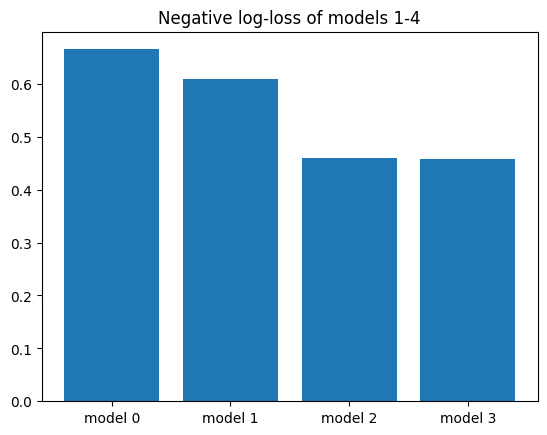

In [12]:
ll = [log_loss(y, y_prob[:, i]) for i in range(len(models))]

plt.title("Negative log-loss of models 1-{}".format(len(models)))
plt.bar(["model " + str(i) for i in range(len(models))], height=ll)

<BarContainer object of 4 artists>

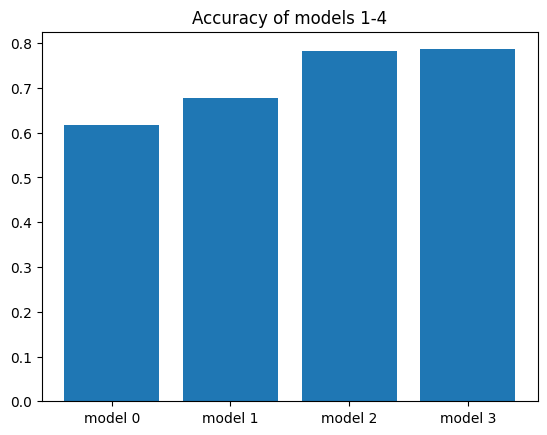

In [13]:
vals = [accuracy_score(y, y_fit[:, i]) for i in range(len(models))]

plt.title("Accuracy of models 1-{}".format(len(models)))
plt.bar(["model " + str(i) for i in range(len(models))], height=vals)

#### Plot survival probabilities
##### Model 3

In [14]:
models[3].coef_

array([[ 3.95441553, -1.09200821, -2.62575288, -0.01591818]])

(0.0, 100.0)

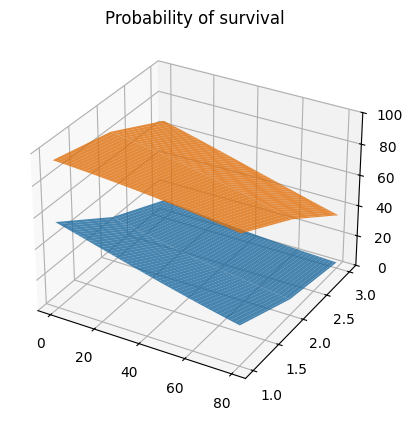

In [15]:
n = 300
m = 100

x_int   = np.ones((n, 1))
x_age   = np.repeat(np.linspace(0, 80, m), 3).reshape(-1, 1)
x_class = np.tile([1, 2, 3], m).reshape(-1, 1)
x_male  = np.repeat([1], n).reshape(-1, 1)

x_plot = np.concatenate((x_int, x_class, x_male, x_age), axis=1)
y_plot = models[3].predict_proba(x_plot)[:, 1]*100

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.set_title("Probability of survival")
ax.plot_surface(x_age.reshape(m, 3), x_class.reshape(100, 3), y_plot.reshape(m, 3), alpha=0.8)

x_male = np.repeat([0], n).reshape(-1, 1)

x_plot = np.concatenate((x_int, x_class, x_male, x_age), axis=1)
y_plot = models[3].predict_proba(x_plot)[:, 1]*100

ax.plot_surface(x_age.reshape(m, 3), x_class.reshape(m, 3), y_plot.reshape(m, 3), alpha=0.8)
ax.set_zlim((0, 100))

#### Plot odds ratio
The odds of survival for a one-unit change in the variable.

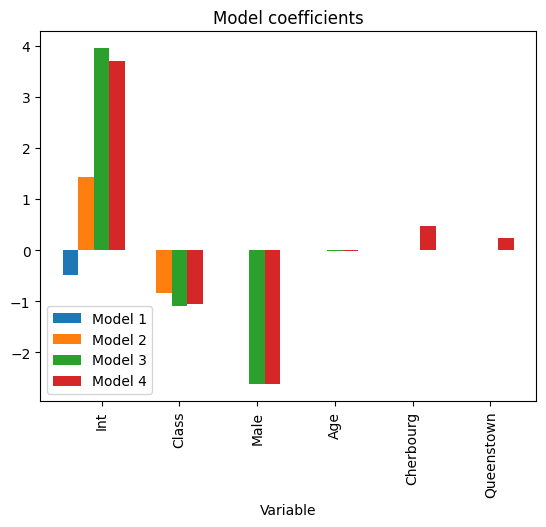

In [16]:
b1 = models[1].coef_.shape[1]
b2 = models[2].coef_.shape[1]
b3 = models[3].coef_.shape[1]
b4 = models[4].coef_.shape[1]

c1 = np.concatenate((models[1].coef_.reshape(b1, 1), np.full((b4-b1, 1), np.nan)), axis=0)
c2 = np.concatenate((models[2].coef_.reshape(b2, 1), np.full((b4-b2, 1), np.nan)), axis=0)
c3 = np.concatenate((models[3].coef_.reshape(b3, 1), np.full((b4-b3, 1), np.nan)), axis=0)
c4 = models[4].coef_.reshape(b4, 1)

#vals = np.exp(np.concatenate((c2, c3, c4), axis=1))
vals = np.concatenate((c1, c2, c3, c4), axis=1)
x = np.arange(vals.shape[0])

for i in range(len(models)):
    plt.bar(x+(i-len(models)/2)/(1+len(models)), vals[:, i], 0.2)

plt.title("Model coefficients")
plt.xticks(x, x_cols[4], rotation = 90)
plt.xlabel("Variable")
plt.legend(["Model " + str(i) for i in range(1, len(models)+2)])


### 4. Cross-validation

So far the models have been fitted to the full dataset, ignoring any overfitting issues and the statistical significance of the variables. Eyeballing the log-loss plot, there is no material improvement from going to model 2 to model 3 (or model 4).

#### K-Fold cross-validation

In [17]:
kn = 50
kf = KFold(n_splits=kn)
LL = np.zeros((kn, len(models), 2))

models_cv = {}
coefs_cv  = {}

for j in range(1, 1+len(models)):
    coefs_cv[j] = np.zeros((kn, models[j].coef_.shape[1]))

for i, (train_rows, test_rows) in enumerate(kf.split(df[x_cols[1]])):
    #print("Fold", i+1, "of", kn)

    for j in range(1, 1+len(models)):

        models_cv[j] = LogisticRegression(penalty=None, fit_intercept=False).fit(df[train_rows, x_cols[j]], y[train_rows])
    
        coefs_cv[j][i, :] = models_cv[j].coef_.ravel()

        LL[i, j-1, 0] = log_loss(y[train_rows], models_cv[j].predict_proba(df[train_rows, x_cols[j]])[:, 1].reshape(-1, 1))
        LL[i, j-1, 1] = log_loss(y[test_rows],  models_cv[j].predict_proba(df[test_rows,  x_cols[j]])[:, 1].reshape(-1, 1))

LC = np.diff(LL, axis=1)

#### Plot boxplot of accuracies and log-losses
Relative to intercept-only model

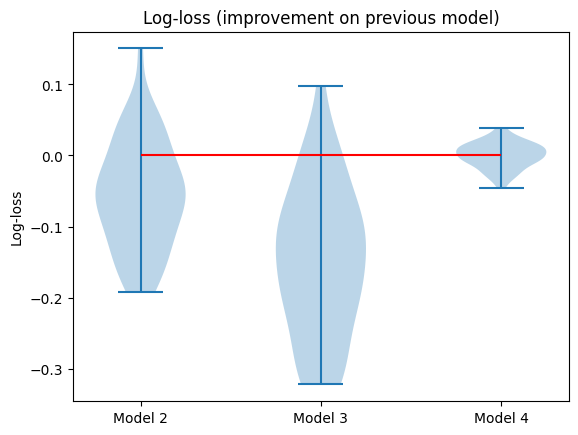

In [18]:
plt.violinplot(LC[:,:,1])
plt.xticks(range(1, len(models)), ["Model " + str(i+1) for i in range(1, len(models))])
plt.title("Log-loss (improvement on previous model)")
plt.ylabel("Log-loss")
plt.hlines([0], xmin=1, xmax=3, colors='red')

#### Plot boxplot of model 4 coefficients

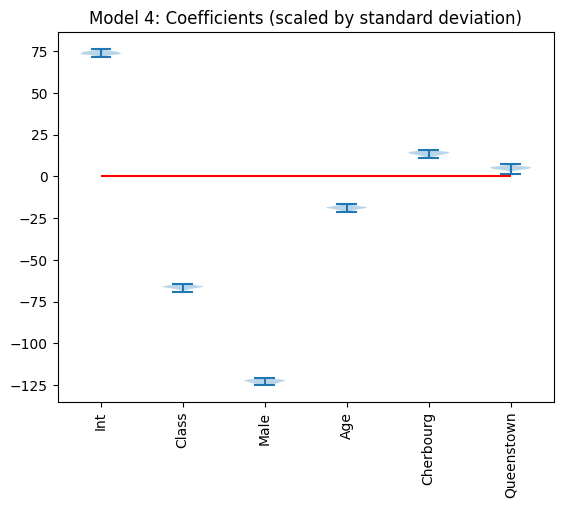

In [22]:
coefs4_sd = np.reshape(np.repeat(coefs_cv[4].std(axis=0), kn), (kn, len(x_cols[4])), order='F')

plt.violinplot(coefs_cv[4] / coefs4_sd);
plt.hlines([0], xmin = 1, xmax = len(x_cols[4]), colors='red');
plt.title("Model 4: Coefficients (scaled by standard deviation)");
plt.xticks(np.arange(len(x_cols[4]))+1, x_cols[4], rotation=90);